In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# %%
# Load the CDD data
cdd_file = "cddid.tbl.gz"
cdd_df = pd.read_csv(cdd_file, sep="\t", header=None, names=["CDD_ID", "Domain_ID", "Gene_Name", "Description", "Length"])
cdd_df = cdd_df[["Domain_ID","Gene_Name"]]
# View first few rows
print(cdd_df)

        Domain_ID     Gene_Name
0        CHL00001          rpoB
1        CHL00002          matK
2        CHL00003          psbA
3        CHL00004          psbD
4        CHL00005         rps16
...           ...           ...
67155  smart01100   CRAL_TRIO_N
67156  smart01101  CRISPR_assoc
67157  smart01102        CRM1_C
67158  smart01103     CRS1_YhbY
67159  smart01104           CTD

[67160 rows x 2 columns]


In [4]:
superfam_df = pd.read_csv("CDDID_SuperfamilyID.txt", sep='\t')
superfam_df.columns = ["CDD_ID_1", "Accession_1", "CDD_ID_2", "Accession_2"]

superfam_df = superfam_df.drop(columns=[ "Accession_1","Accession_2" ])
# Rename columns for clarity
superfam_df.columns = ["CDD_ID", "Superfamily"]

# Drop duplicates if any
superfam_df = superfam_df.drop_duplicates()
#superfam_df

In [5]:

RNA_seq_df = pd.read_csv("amphimedon_rnaseq.txt", sep='\t')
#RNA_seq_df.head(1)

In [6]:
setsub_seq_df = pd.read_csv("SETSubfamilies(1).txt", delim_whitespace=True)
setsub_seq_df.columns = ['CDD_ID', 'Gene_Name', 'Subfamily_CDDID']

#setsub_seq_df[['CDD_ID','Gene_ID','Subfamily_CDDID']] =setsub_seq_df["CDD_ID Gene Name Subfamily CDD_ID"].str.split(r"\s+", n=1, expand=True)
#setsub_seq_df = setsub_seq_df.drop(columns=["CDD_ID Gene Name   Subfamily CDD_ID"])
print(setsub_seq_df.columns)
setsub_seq_df

Index(['CDD_ID', 'Gene_Name', 'Subfamily_CDDID'], dtype='object')


C:\Users\ssali\AppData\Local\Temp\ipykernel_23268\658321785.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  setsub_seq_df = pd.read_csv("SETSubfamilies(1).txt", delim_whitespace=True)


,CDD_ID,Gene_Name,Subfamily_CDDID
0,cd08161,SET,cd08161
1,cd10518,SETD1-like,cd10518
2,cd19169,SETD1,cd10518
3,cd19204,SETD1A,cd10518
4,cd19205,SETD1B,cd10518
...,...,...,...
81,cd10536,SMYD4,cd20071
82,cd19167,SMYD1/2/3-like,cd20071
83,cd10526,SMYD1,cd20071
84,cd19202,SMYD2,cd20071


In [7]:
cddid_df = pd.read_csv("mart_export (2).txt", sep='/t')
cddid_df[['Gene_ID', 'CDD_ID']] = cddid_df["Gene stable ID	CDD ID"].str.split("\t", expand=True)
# Drop the old combined column
cddid_df = cddid_df.drop(columns=["Gene stable ID	CDD ID"])
#cddid_df

C:\Users\ssali\AppData\Local\Temp\ipykernel_23268\3647494203.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cddid_df = pd.read_csv("mart_export (2).txt", sep='/t')


In [8]:
merged_df = cddid_df.merge(superfam_df, on='CDD_ID')
df_merged = merged_df.merge(cdd_df, left_on="Superfamily", right_on="Domain_ID", how="left")

# Append gene names directly to the Superfamily column
df_merged["Superfamily"] = df_merged["Superfamily"] + ": " + df_merged["Gene_Name"]

df_merged.drop(columns=["Domain_ID"], inplace=True)
merged_df=df_merged
df_merged

,Gene_ID,CDD_ID,Superfamily,Gene_Name
0,LOC100631963,cd04458,cl09927: S1_like,S1_like
1,LOC100631963,cd04458,cl09927: S1_like,S1_like
2,LOC105316874,cd16620,cl17238: RING_Ubox,RING_Ubox
3,LOC100637711,cd02809,cl21457: TIM,TIM
4,LOC109584330,cd01670,cl14633: DD,DD
...,...,...,...,...
10867,LOC105313484,cd15863,cl22856: SNARE,SNARE
10868,LOC109583428,cd00096,cl11960: Ig,Ig
10869,LOC109583428,cd00096,cl11960: Ig,Ig
10870,LOC100640765,cd00472,cl00909: Ribosomal_L24e_L24,Ribosomal_L24e_L24


In [9]:
final_df = merged_df.merge(RNA_seq_df, left_on="Gene_ID", right_on="GeneID", how="inner")
final_df["CDD_ID"]
finals_df = final_df.merge(setsub_seq_df,on= "CDD_ID",how="inner")
finals_df.drop(columns=["Superfamily","Gene_Name_x","GeneID"], inplace=True)
finals_df

,Gene_ID,CDD_ID,TranscriptID,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae,Gene_Name_y,Subfamily_CDDID
0,LOC105313292,cd19172,XM_019998283.1,19.370,90.691,62.979,65.074,60.205,42.705,34.215,60.883,SETD2,cd10531
1,LOC105313292,cd19172,XM_019998282.1,10.640,26.351,16.580,20.707,19.333,53.277,10.435,18.082,SETD2,cd10531
2,LOC105313292,cd19172,XM_019998283.1,19.370,90.691,62.979,65.074,60.205,42.705,34.215,60.883,SETD2,cd10531
3,LOC105313292,cd19172,XM_019998282.1,10.640,26.351,16.580,20.707,19.333,53.277,10.435,18.082,SETD2,cd10531
4,LOC105312696,cd19176,XM_011405548.2,33.877,31.628,12.554,9.664,10.465,11.898,10.372,18.388,SETD3,cd10527
5,LOC105313876,cd10529,XM_020000342.1,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778,SETD5-like,cd10529
6,LOC100635065,cd10537,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SETD9,cd10537
7,LOC100635065,cd10537,XM_019997323.1,6.581,0.677,1.631,0.899,1.911,1.145,2.074,4.535,SETD9,cd10537
8,LOC100635065,cd10537,XR_002185158.1,0.269,1.046,1.294,0.740,0.091,0.631,1.030,0.248,SETD9,cd10537
9,LOC100635065,cd10537,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SETD9,cd10537


In [40]:
# Drop unnecessary columns
Superfamily_Transcript_df = finals_df.drop(columns=['Gene_ID', 'CDD_ID'])

#  Keep all unique Subfamily-TranscriptID combinations
df_unique = Superfamily_Transcript_df.drop_duplicates(subset=["Subfamily_CDDID", "TranscriptID"])

#  Sum TPM values per Subfamily_CDDID, keeping one representative Gene_Name_y
df_summed = df_unique.groupby("Subfamily_CDDID").agg({
    "Gene_Name_y": "first",  # take one gene name per subfamily
    **{col: "sum" for col in df_unique.columns if col not in ["Subfamily_CDDID", "Gene_Name_y", "TranscriptID"]}
}).reset_index()

output_file = 'unique_TPM_expression_amph_part2.txt'
df_summed.to_csv(output_file, sep='\t', index=False)

# Log2 transform of numeric TPM columns (replace 0s for log-safety)
numeric_cols = df_summed.columns.difference(["Subfamily_CDDID", "Gene_Name_y"])
df_loged = np.log2(df_summed[numeric_cols].replace(0, 0.5) + 0.5)

# Add identifiers back to the log dataframe
df_loged["Subfamily_CDDID"] = df_summed["Subfamily_CDDID"]
df_loged["Gene_Name"] = df_summed["Gene_Name_y"]


df_loged = df_loged.sort_values(by="Gene_Name", ascending=True)
#df_loged.drop(columns=["Gene_Name"], inplace=True)

# Result
df_loged

,Sample.Brown,Sample.Cleavage,Sample.Cloud,Sample.Free.swimming.larvae,Sample.Late.ring,Sample.Late.spot,Sample.Ring,Sample.Spot,Subfamily_CDDID,Gene_Name
6,3.167519,3.213347,1.893751,1.651224,1.813114,0.994942,2.041944,0.882839,cd10534,PRDM7/9
0,7.427380,6.991545,7.589868,8.466713,7.357050,6.663160,6.868353,7.177838,cd10518,SETD1
5,7.207161,5.647976,6.665833,6.571009,5.905014,6.475198,6.680085,6.533921,cd10531,SETD2
1,5.304182,5.467214,4.440554,4.687061,4.418325,4.088905,4.361207,4.089752,cd10527,SETD3
3,6.121989,6.087526,5.562609,6.543465,6.456067,5.270080,4.524440,5.156356,cd10529,SETD5-like
4,3.643972,2.696662,2.557288,3.790146,3.182692,1.706199,2.279471,2.574828,cd10530,SETD7
2,3.663914,2.162532,4.948414,2.661294,1.429214,3.097442,1.836732,3.811779,cd10528,SETD8
7,4.449099,4.790042,3.194875,5.022412,3.496718,2.702436,2.652372,3.204610,cd10537,SETD9
8,5.381387,4.533190,5.619120,3.756490,3.449561,4.805499,4.154454,4.820230,cd10538,SUV39H


In [11]:
output_file = 'unique_TPM_expression_amph.txt'
df_loged.to_csv(output_file, sep='\t', index=False)
df_loged

,Sample.Brown,Sample.Cleavage,Sample.Cloud,Sample.Free.swimming.larvae,Sample.Late.ring,Sample.Late.spot,Sample.Ring,Sample.Spot,Subfamily_CDDID,Gene_Name
6,3.167519,3.213347,1.893751,1.651224,1.813114,0.994942,2.041944,0.882839,cd10534,PRDM7/9
0,7.427380,6.991545,7.589868,8.466713,7.357050,6.663160,6.868353,7.177838,cd10518,SETD1
5,7.207161,5.647976,6.665833,6.571009,5.905014,6.475198,6.680085,6.533921,cd10531,SETD2
1,5.304182,5.467214,4.440554,4.687061,4.418325,4.088905,4.361207,4.089752,cd10527,SETD3
3,6.121989,6.087526,5.562609,6.543465,6.456067,5.270080,4.524440,5.156356,cd10529,SETD5-like
4,3.643972,2.696662,2.557288,3.790146,3.182692,1.706199,2.279471,2.574828,cd10530,SETD7
2,3.663914,2.162532,4.948414,2.661294,1.429214,3.097442,1.836732,3.811779,cd10528,SETD8
7,4.449099,4.790042,3.194875,5.022412,3.496718,2.702436,2.652372,3.204610,cd10537,SETD9
8,5.381387,4.533190,5.619120,3.756490,3.449561,4.805499,4.154454,4.820230,cd10538,SUV39H


In [12]:
df_heat = df_summed.loc[:, df_summed.columns.str.startswith("Sample")]

df_heat.head()

,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae
0,126.752,171.633,192.154,144.292,100.847,116.337,163.443,353.281
1,43.738,39.011,21.214,16.527,16.517,20.052,20.882,25.260
2,3.977,12.175,30.376,13.543,8.059,3.072,2.193,5.826
3,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778
4,5.983,12.001,5.386,5.458,2.763,4.355,8.580,13.334


In [13]:
row_mean = df_heat.mean(axis=1)
log_mean = np.log2(row_mean)
log_mean

0    7.418632
1    4.666764
2    3.307811
3    5.843136
4    2.854494
5    6.520843
6    2.026180
7    3.912530
8    4.703558
dtype: float64

In [14]:
numeric_cols = df_heat.select_dtypes(include='number')
df_centered = numeric_cols.sub(log_mean, axis=0)
df_centered.head()

,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae
0,119.333368,164.214368,184.735368,136.873368,93.428368,108.918368,156.024368,345.862368
1,39.071236,34.344236,16.547236,11.860236,11.850236,15.385236,16.215236,20.593236
2,0.669189,8.867189,27.068189,10.235189,4.751189,-0.235811,-1.114811,2.518189
3,61.659864,63.303864,40.918864,29.319864,32.244864,16.670864,81.451864,86.934864
4,3.128506,9.146506,2.531506,2.603506,-0.091494,1.500506,5.725506,10.479506


In [15]:
max_value = df_centered.max().max()

min_value = df_centered.min().min()

print("Max value:", max_value)
print("Min value:", min_value)

Max value: 345.86236834493224
Min value: -1.114811007262631


In [16]:
finals_df

,Gene_ID,CDD_ID,TranscriptID,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae,Gene_Name_y,Subfamily_CDDID
0,LOC105313292,cd19172,XM_019998283.1,19.370,90.691,62.979,65.074,60.205,42.705,34.215,60.883,SETD2,cd10531
1,LOC105313292,cd19172,XM_019998282.1,10.640,26.351,16.580,20.707,19.333,53.277,10.435,18.082,SETD2,cd10531
2,LOC105313292,cd19172,XM_019998283.1,19.370,90.691,62.979,65.074,60.205,42.705,34.215,60.883,SETD2,cd10531
3,LOC105313292,cd19172,XM_019998282.1,10.640,26.351,16.580,20.707,19.333,53.277,10.435,18.082,SETD2,cd10531
4,LOC105312696,cd19176,XM_011405548.2,33.877,31.628,12.554,9.664,10.465,11.898,10.372,18.388,SETD3,cd10527
5,LOC105313876,cd10529,XM_020000342.1,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778,SETD5-like,cd10529
6,LOC100635065,cd10537,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SETD9,cd10537
7,LOC100635065,cd10537,XM_019997323.1,6.581,0.677,1.631,0.899,1.911,1.145,2.074,4.535,SETD9,cd10537
8,LOC100635065,cd10537,XR_002185158.1,0.269,1.046,1.294,0.740,0.091,0.631,1.030,0.248,SETD9,cd10537
9,LOC100635065,cd10537,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SETD9,cd10537


In [17]:
df_summed


,Subfamily_CDDID,Gene_Name_y,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae
0,cd10518,SETD1,126.752,171.633,192.154,144.292,100.847,116.337,163.443,353.281
1,cd10527,SETD3,43.738,39.011,21.214,16.527,16.517,20.052,20.882,25.260
2,cd10528,SETD8,3.977,12.175,30.376,13.543,8.059,3.072,2.193,5.826
3,cd10529,SETD5-like,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778
4,cd10530,SETD7,5.983,12.001,5.386,5.458,2.763,4.355,8.580,13.334
5,cd10531,SETD2,49.643,147.265,101.035,92.163,88.467,102.043,59.422,94.576
6,cd10534,PRDM7/9,8.775,8.485,3.216,1.344,1.493,3.618,3.014,2.641
7,cd10537,SETD9,27.166,21.343,8.657,8.719,6.009,5.787,10.788,32.001
8,cd10538,SUV39H,22.654,41.183,48.650,27.751,27.464,17.308,10.425,13.015


In [18]:
import matplotlib.colors as mcolors

C:\Users\ssali\AppData\Local\Temp\ipykernel_23268\1890123319.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Fig. project 1 part 2.The superfamily domains have been transformed to log2 TPM values.\nTheir prevalence is centered on the row mean.",


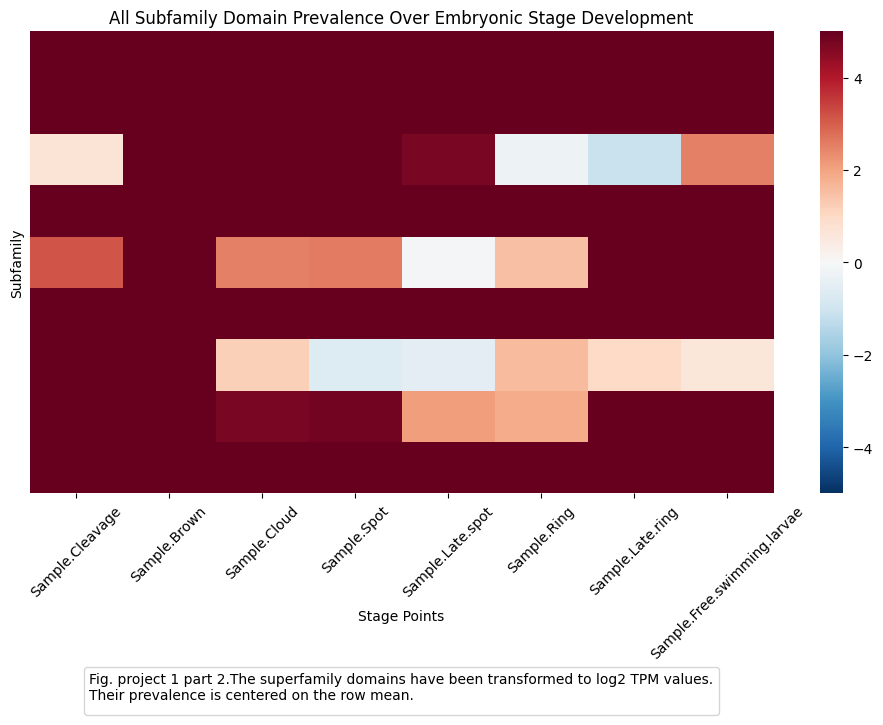

In [19]:
plt.figure(figsize=(12, 6))
normalize = mcolors.TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5)
ax = plt.gca()

sns.heatmap(df_centered, cmap="RdBu_r", norm = normalize)
plt.xlabel("Stage Points")
ax.xaxis.set_label_coords(0.5, -0.25)
plt.ylabel("Subfamily")
plt.title("All Subfamily Domain Prevalence Over Embryonic Stage Development")
plt.xticks(rotation=45)
plt.legend(title="Fig. project 1 part 2.The superfamily domains have been transformed to log2 TPM values.\nTheir prevalence is centered on the row mean.",
           loc='upper center',
           bbox_to_anchor=(0.5, -0.36),
           ncol = 20)
plt.yticks([])
plt.show()

C:\Users\ssali\AppData\Local\Temp\ipykernel_23268\1097153322.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Fig 1. SET Subfamilies of Amphimedon \n transformed using maxfold change and \n ranked by prevalance within early stages of life",


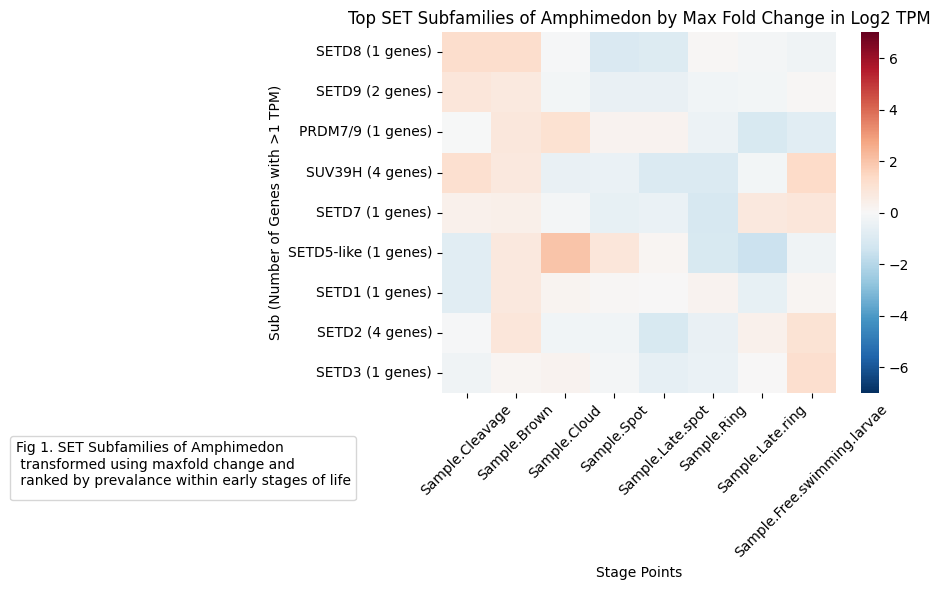

<Figure size 640x480 with 0 Axes>

In [39]:
tpm_columns = [col for col in df_summed.columns if col.startswith('Sample.')]
df_summed['Max_Fold_Change'] = df_summed[tpm_columns].max(axis=1) / (df_summed[tpm_columns].min(axis=1) + 0.5)

#sort based on df_summed["Max_Fold_Change"]
df_sortMX = df_summed.sort_values(by='Max_Fold_Change', ascending=False)

gene_counts = finals_df[finals_df[tpm_columns].gt(1).all(axis=1)].groupby('Gene_Name_y').size().reset_index(name='Gene_Count')
gene_counts = gene_counts[gene_counts['Gene_Count'] > 0]
#merge gene counts
df_summed_W_genecount = df_sortMX.merge(gene_counts, on='Gene_Name_y', how='left')
#drop na
df_summed_W_genecount = df_summed_W_genecount.dropna(subset=['Gene_Count']) 


top_20_superfamilies = df_summed_W_genecount.head(20)

heatmap_data = top_20_superfamilies.set_index('Gene_Name_y')[tpm_columns]

heatmap_data_log2 = np.log2(heatmap_data + 0.5)

row_mean = heatmap_data_log2.mean(axis=1)
heatmap_data_centered = heatmap_data_log2.sub(row_mean, axis=0)

heatmap_data_centered["log2_diff"] = heatmap_data_log2["Sample.Cleavage"] - heatmap_data_log2["Sample.Free.swimming.larvae"]
heatmap_data_sorted = heatmap_data_centered.sort_values(by="log2_diff", ascending=False)
heatmap_data_sorted = heatmap_data_sorted.drop("log2_diff", axis=1)

row_labels = [f"{superfamily} ({count} genes)" for superfamily, count in zip(top_20_superfamilies['Gene_Name_y'], top_20_superfamilies['Gene_Count'])]

# Plot the smaller heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data_sorted,
    cmap="RdBu_r",
    yticklabels=row_labels,
    vmin=-7,
    vmax=7,
)

plt.title('Top SET Subfamilies of Amphimedon by Max Fold Change in Log2 TPM')
plt.xlabel('Stage Points')
plt.ylabel('Sub (Number of Genes with >1 TPM)')
plt.legend(title="Fig 1. SET Subfamilies of Amphimedon \n transformed using maxfold change and \n ranked by prevalance within early stages of life",
           loc='best',
           bbox_to_anchor=(-0.2, -0.10))
plt.xticks(rotation=45)
plt.tight_layout()
plt.draw()
plt.show()
plt.savefig('Top Domains Heatmap- drosophila.pdf')



